# Specter embeddings

In this notebook, we perform a clustering analysis of COVID-19 publications using [SPECTRE embeddings](https://github.com/allenai/paper-embedding-public-apis).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [3]:
df_meta = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [4]:
import re

def clean_year(s):
    if pd.isna(s):
        return np.nan
    if not (s>1900):
        return np.nan
    elif s>2020:
        return 2020
    return s

df_meta["publication_year"] = df_meta["publication_year"].apply(clean_year)

In [5]:
df_meta.abstract = df_meta['abstract'].fillna('')
df_meta.title = df_meta['title'].fillna('')

In [6]:
df_meta.head()

pub_id                                              title  \
0       0  ‘A ticking time bomb’: Scientists worry about ...   
1       1  [Ten hot issues of breast cancer under the nov...   
2       2  Another Piece of the Puzzle: Human Metapneumov...   
3       3  Viral etiology of severe pneumonia among Kenya...   
4       4  Critically Ill Patients With Influenza A(H1N1)...   

                                            abstract  publication_year  \
0  CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...            2020.0   
1                                                               2020.0   
2  BACKGROUND: Each winter respiratory viruses ac...            2008.0   
3  CONTEXT: Pneumonia is the leading cause of chi...            2010.0   
4                                                               2014.0   

   publication_month                        journal volume issue pages  \
0                NaN                        Science    NaN   NaN   NaN   
1                2.0        Chinese medical journal    100     0  e002   
2               12.0  Archives of Internal Medicine    NaN   NaN   NaN   
3                5.0                           JAMA    NaN   NaN   NaN   
4                4.0                           JAMA    NaN   NaN   NaN   

                                      doi        pmid       pmcid  \
0                  0.1126/science.abb7331         NaN         NaN   
1  10.0376/cma.j.issn.0376-2491.2020.0002  32036640.0         NaN   
2            10.1001/archinte.168.22.2489  19064834.0  pmc2783624   
3                   10.1001/jama.2010.675  20501927.0  pmc2968755   
4                  10.1001/jama.2014.2116  24566924.0  pmc6689404   

    dimensions_id                   timestamp  
0             NaN  2020-04-18 09:20:24.986698  
1  pub.1124777091  2020-04-18 09:20:24.986698  
2             NaN  2020-04-18 09:20:24.986698  
3             NaN  2020-04-18 09:20:24.986698  
4             NaN  2020-04-18 09:20:24.986698

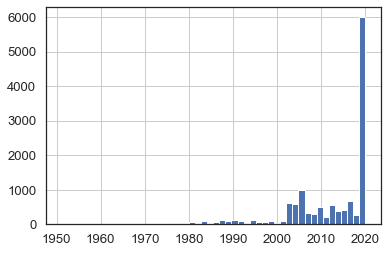

In [7]:
df_meta[(df_meta.abstract=="") & (df_meta.publication_year<2021)].publication_year.hist(bins=50)

In [8]:
ALL_PAPERS = list()
for pid,t,a in zip(df_meta.pub_id.to_list(),df_meta.title.to_list(),df_meta.abstract.to_list()):
    if len(t) and len(a):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":a})
    elif len(t):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":t}) # we use the title as abstract (THIS NEEDS TO BE CHECKED)
    else:
        continue

In [9]:
df_meta.shape

(61482, 14)

In [10]:
len(ALL_PAPERS)

61324

In [11]:
paper_to_id = {n:pid["paper_id"] for n,pid in enumerate(ALL_PAPERS)}

### Query SPECTER API

In [11]:
# From https://github.com/allenai/paper-embedding-public-apis

from typing import Dict, List
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16


def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]


def embed(papers):
    embeddings_by_paper_id: Dict[str, List[float]] = {}
        
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    for n,chunk in enumerate(chunks(papers)):
        # Allow Python requests to convert the data above to JSON
        response = session.post(URL, json=chunk)

        if response.status_code != 200:
            print(chunk)
            #raise RuntimeError("Sorry, something went wrong, please try later!")
            continue

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]
        #print(n)
        if n%1000 == 0:
            print("Done chunk",n)

    return embeddings_by_paper_id

In [12]:
#all_embeddings = embed(ALL_PAPERS)

In [15]:
#pickle.dump(all_embeddings,open("data/specter_embeddings.pk","wb"))

In [12]:
all_embeddings = pickle.load(open("data/specter_embeddings.pk","rb"))

In [13]:
len(all_embeddings)

61324

In [14]:
len(ALL_PAPERS)

61324

In [15]:
X = np.matrix([v for v in all_embeddings.values()])

In [16]:
X.shape

(61324, 768)

### t-SNE

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, perplexity=50, early_exaggeration=15, n_iter=2000, random_state=seed, metric='cosine', n_jobs=6)
X_embedded = tsne.fit_transform(X)

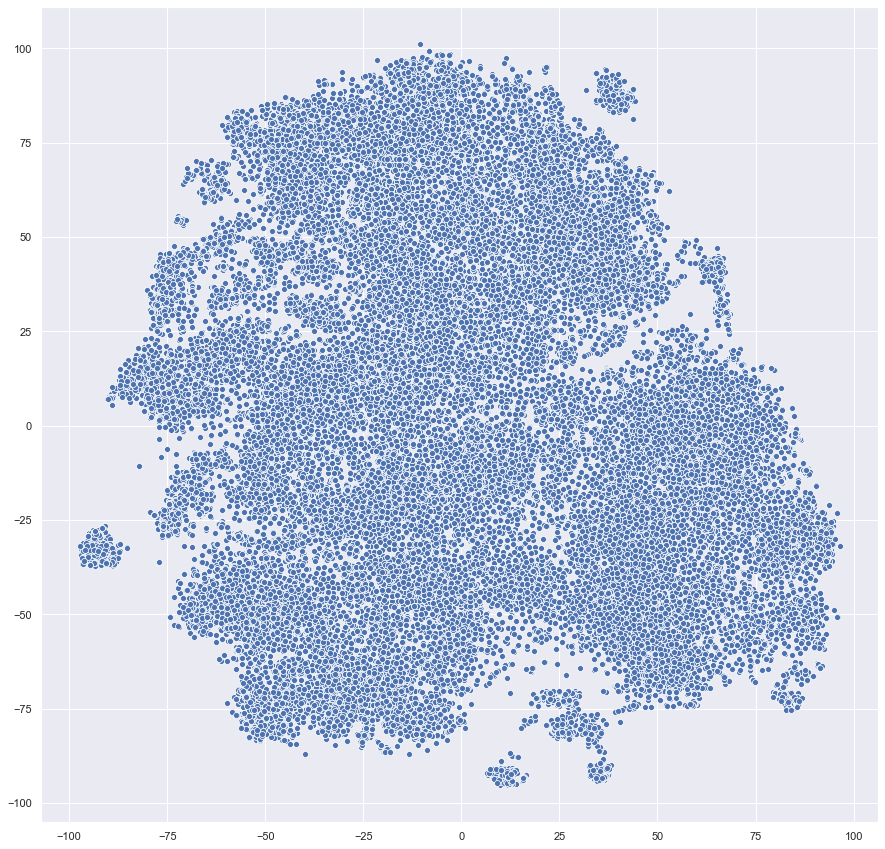

In [18]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
#plt.title('t-SNE with no Labels')
plt.savefig("figures/nb3_tsne_vanilla.pdf")
plt.show()

In [19]:
# create a vector with in_wikipedia or not for all papers with embeddings

y = list()
             
inwiki = df_joined_all[df_joined_all.in_wikipedia==1].pub_id.to_list()
                 
for n,k in enumerate(all_embeddings.keys()):
    if k in inwiki:
        y.append(1)
    else:
        y.append(0)

In [20]:
y = np.array(y)

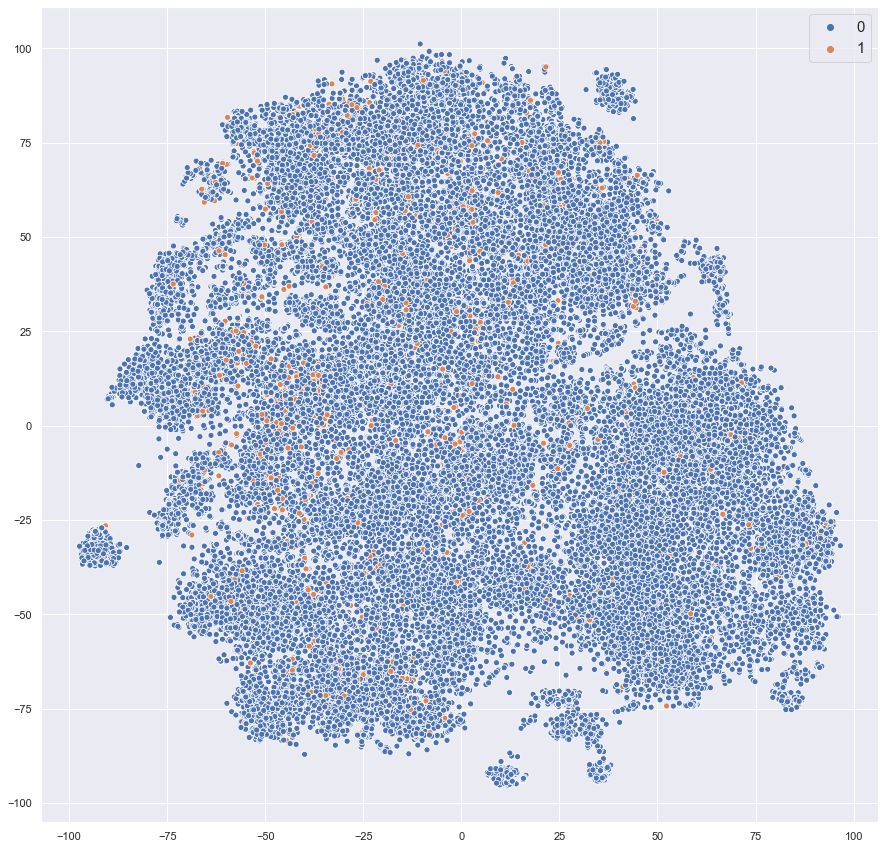

In [21]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
#palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')#, palette=palette)
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=15)
plt.savefig("figures/nb3_tsne_in_wiki.pdf")
plt.show()

### K-means

In [22]:
# number of clusters
# see below for Elbow and Silouhette analyses 
k = 20

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, random_state=seed, max_iter=1000, n_jobs=6)
y_pred = kmeans.fit_predict(X)

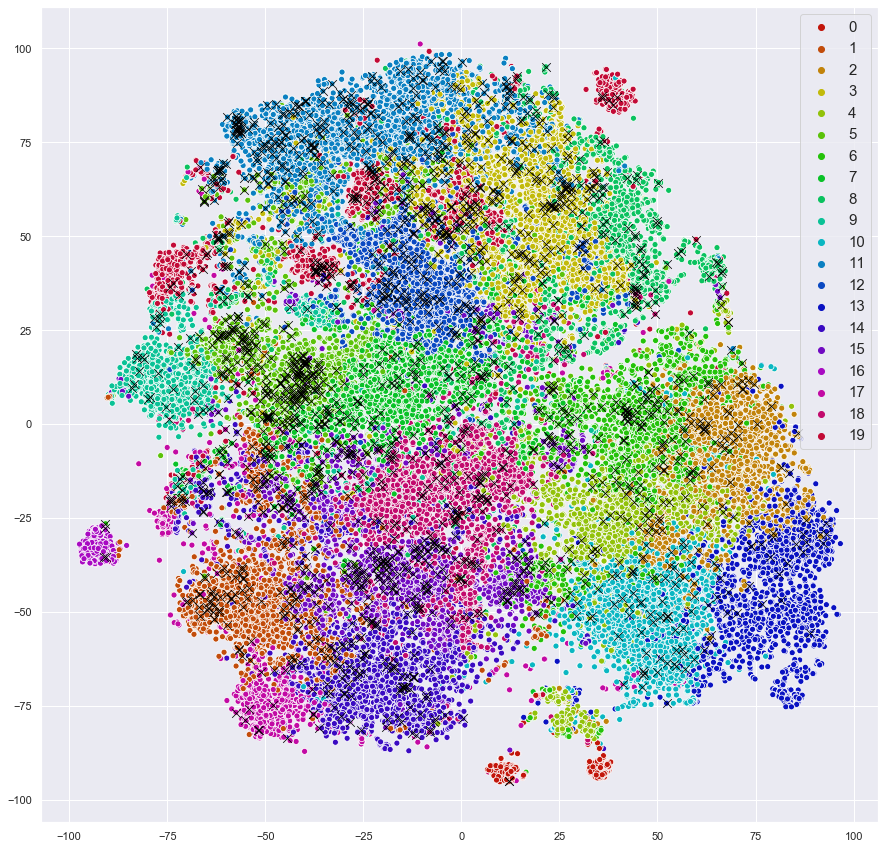

In [24]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
sns.scatterplot(X_embedded[y==1][:,0], X_embedded[y==1][:,1], legend=False, marker="x", color="black", s=75)#, palette=palette)
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=15)
plt.savefig("figures/nb_3_tsne_kmeans_in_wiki.pdf")
plt.show()

In [25]:
# list closest 10 papers to centroids
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X, metric='cosine')
closest

array([11536, 61094, 51164, 37973, 54564, 22217,  5192, 42608, 42036,
       17819,  6169, 37962, 28270,  8253, 47845, 59689, 48526, 50272,
       32879, 26949])

In [26]:
for n,c in enumerate(closest):
    print("Cluster",n,df_meta.iloc[paper_to_id[c]].title)

Cluster 0 Revisión sobre las infecciones no bacterianas del aparato respiratorio: neumonías víricas
Cluster 1 Mathematical Modeling of Epidemic Diseases; A Case Study of the COVID-19 Coronavirus
Cluster 2 Emergence and Control of Viral Respiratory Diseases
Cluster 3 Murine Coronavirus Delays Expression of a Subset of Interferon-Stimulated Genes
Cluster 4 [Cardiac manifestations of patients with COVID-19 pneumonia and related treatment recommendations].
Cluster 5 Molecular characterization of a canine respiratory coronavirus strain detected in Italy
Cluster 6 Clinical trials for the treatment of Coronavirus disease 2019 (COVID-19): A rapid response to urgent need
Cluster 7 S1 gene sequence analysis of a nephropathogenic strain of avian infectious bronchitis virus in Egypt
Cluster 8 Endogenous annexin A1 counter-regulates bleomycin-induced lung fibrosis
Cluster 9 Evaluation of a single-tube fluorogenic RT-PCR assay for detection of bovine respiratory syncytial virus in clinical samples
C

In [27]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [28]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for c in range(k):
    cl_size = len(y_pred[y_pred==c])
    coverage = len(y_pred[(y==1)&(y_pred==c)])/cl_size
    #print("Cluster",c,coverage)
    cluster_coverage.append(coverage)
    cluster_size.append(cl_size)
    cluster_number.append(c)

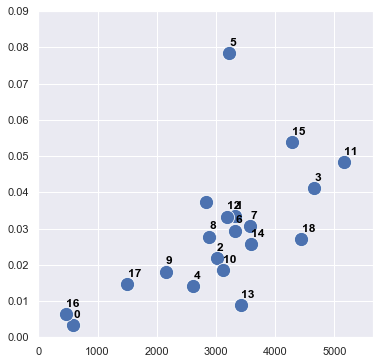

In [44]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in range(k):
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.09))
plt.xlim((0,max(cluster_size)+500))
#plt.legend(fontsize=15)
plt.savefig("figures/nb3_cluster_size_vs_wiki_coverage.pdf")

In [30]:
# plot indicators per in Wikipedia per cluster (e.g., age, citations, etc.)

In [49]:
# export cluster identity and semantic centrality of each paper

from sklearn.metrics.pairwise import cosine_similarity

cluster_semantic_similarities = list()

for k,centroid in enumerate(kmeans.cluster_centers_):
    cos_sim = cosine_similarity(centroid.reshape((1,X.shape[1])), X)
    cluster_semantic_similarities.append(cos_sim)

In [34]:
S = np.stack([s.ravel() for s in cluster_semantic_similarities],axis=1)

In [35]:
S.shape

(61324, 20)

In [36]:
# find the similarity with cluster centroid
T = S[np.arange(len(S)),y_pred]

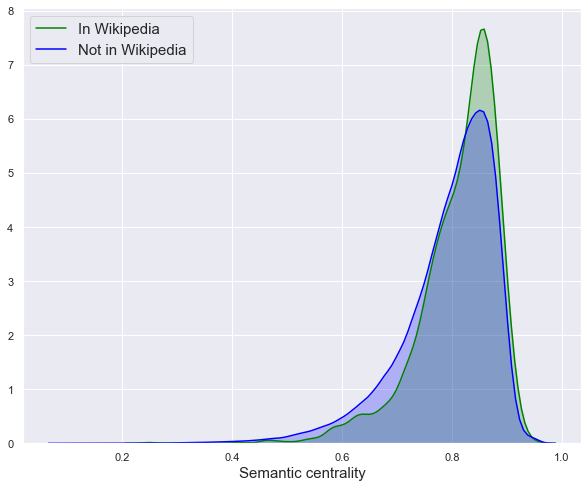

In [52]:
# distribution of semantic centrality for papers cited from Wikipedia or not
plt.figure(figsize=(10,8))
sns.distplot(T[y==1], color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(T[y==0], color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("Semantic centrality",fontsize=15)
plt.savefig("figures/nb3_semantic_centrality.pdf")

In [ ]:
# create data frame and export

In [38]:
pub_ids = list()
cluster_ids = list()
semantic_centralities = list()

for n in range(len(y)):
    pub_ids.append(paper_to_id[n])
    cluster_ids.append(y_pred[n])
    semantic_centralities.append(T[n])

In [39]:
df_specter = pd.DataFrame.from_dict({"pub_id":pub_ids,"cluster_id":cluster_ids,"semantic_centrality":semantic_centralities})
df_specter.to_csv("data/df_spectre.csv", index=False, compression="gzip")

### Topic models

In [99]:
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")

In [100]:
df_topic_intensity.head()

Coronavirus outbreaks  Public health  Epidemics  Animal transmission  \
0               0.200656       0.472949   0.246007             0.054535   
1               0.256909       0.000000   0.000000             0.000000   
2               0.000000       0.012961   0.000000             0.000000   
3               0.000000       0.026788   0.000000             0.024880   
4               0.322807       0.000000   0.000000             0.097959   

   Molecular biology  Respiratory diseases  Immunology  Systematic reviews  \
0                0.0              0.000000    0.018858            0.000000   
1                0.0              0.000000    0.315510            0.347541   
2                0.0              0.982300    0.000000            0.000000   
3                0.0              0.913815    0.015020            0.000000   
4                0.0              0.279916    0.246759            0.000000   

   Diagnosing    year                                     doi  pub_id  
0    0.000000  2020.0                  0.1126/science.abb7331       0  
1    0.000000  2020.0  10.0376/cma.j.issn.0376-2491.2020.0002       1  
2    0.000000  2008.0            10.1001/archinte.168.22.2489       2  
3    0.016966  2010.0                   10.1001/jama.2010.675       3  
4    0.000000  2014.0                  10.1001/jama.2014.2116       4

In [101]:
df_topic_intensity.columns

Index(['Coronavirus outbreaks', 'Public health', 'Epidemics',
       'Animal transmission', 'Molecular biology', 'Respiratory diseases',
       'Immunology', 'Systematic reviews', 'Diagnosing', 'year', 'doi',
       'pub_id'],
      dtype='object')

In [102]:
topic_labels = ['Coronavirus outbreaks', 'Public health', 'Epidemics',
       'Animal transmission', 'Molecular biology', 'Respiratory diseases',
       'Immunology', 'Systematic reviews', 'Diagnosing']

In [103]:
pub_ids = [paper_to_id[n] for n in range(len(paper_to_id))]
df_embeddings = pd.DataFrame.from_dict({"pub_id":pub_ids,"cluster":y_pred})

In [104]:
df_embeddings.shape

(61324, 2)

In [105]:
df_topic_intensity.shape

(61482, 12)

In [106]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")
#df_embeddings = df_embeddings.merge(df_joined_all[["pub_id","in_wikipedia","title"]], how="inner", left_on="pub_id", right_on="pub_id")

In [107]:
df_embeddings.shape

(61324, 13)

In [153]:
which_cluster = 5

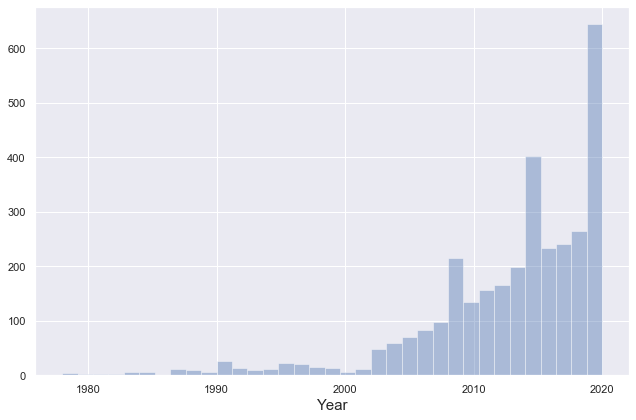

In [154]:
plt.figure(figsize=(9,6))
sns.distplot(df_embeddings[df_embeddings.cluster == which_cluster].year, bins=35, kde=False)
plt.xlabel("Year",fontsize=15)
plt.tight_layout()
#plt.savefig("figures/nb3_cluster_%d_yeardistr.pdf"%(which_cluster))

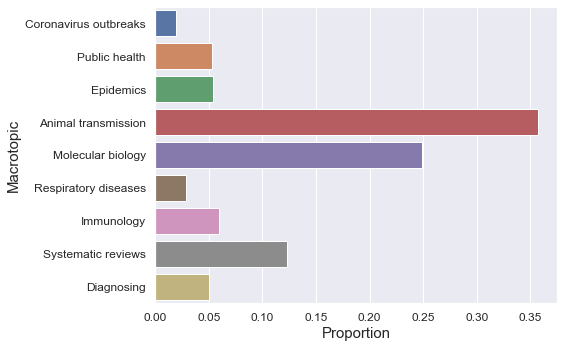

In [155]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.cluster == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb3_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [156]:
# examples of central papers in a cluster

df_specter[df_specter.cluster_id==which_cluster].merge(df_meta[["title","publication_year","journal","pub_id"]], how="left", right_on="pub_id", left_on="pub_id").sort_values("semantic_centrality",ascending=False).head(20)

pub_id  cluster_id  semantic_centrality  \
1069   22368           5             0.923144   
1824   35407           5             0.919747   
1121   22605           5             0.918663   
2627   45910           5             0.918459   
1692   33607           5             0.917951   
1156   23769           5             0.917627   
1000   21895           5             0.917626   
2050   38335           5             0.916351   
2876   52255           5             0.916304   
2649   46130           5             0.914426   
1401   29757           5             0.913752   
2635   46023           5             0.913687   
162     3403           5             0.913298   
2739   47010           5             0.913094   
1070   22372           5             0.912858   
1494   31449           5             0.912540   
2988   53792           5             0.912480   
202     4042           5             0.912116   
2479   43909           5             0.911774   
1695   33632           5             0.911632   

                                                  title  publication_year  \
1069  Molecular characterization of a canine respira...            2009.0   
1824  Phylogenetic Analysis of the Novel Coronavirus...            2020.0   
1121  Full genome characterization of two novel Alph...            2019.0   
2627  The Role of Viral Population Diversity in Adap...            2013.0   
1692  The 2019-new Coronavirus epidemic: evidence fo...            2020.0   
1156  Genomic characterisation and epidemiology of 2...            2020.0   
1000  Analysis of the genome sequence of an alpaca c...            2007.0   
2050  Identification of Diverse Alphacoronaviruses a...            2014.0   
2876  Molecular characterization of a unique variant...            2019.0   
2649  A Preliminary Study of Viral Metagenomics of F...            2014.0   
1401  Venezuelan encephalitis emergence mediated by ...            2006.0   
2635  Characterization of Synthetic Chikungunya Viru...            2013.0   
162   A complete sequence and comparative analysis o...            2003.0   
2739  The Effect of Vaccination on the Evolution and...            2010.0   
1070  Molecular characterization of a new PToV strai...            2009.0   
1494  Genomic diversity of SARS-CoV-2 in Coronavirus...            2020.0   
2988  Characterization of a New Member of Alphacoron...            2019.0   
202   Full-length genome sequence and genetic relati...            2007.0   
2479  Detection and full genome characterization of ...            2017.0   
1695  Insights into Cross-species Evolution of Novel...            2020.0   

                                              journal  
1069                                   Virus Research  
1824                                              NaN  
1121                                   Virus Research  
2627                                         PLoS One  
1692                                          bioRxiv  
1156                                       The Lancet  
1000                                         Virology  
2050                              Journal of Virology  
2876                                  Poultry Science  
2649                                         PLoS One  
1401  Proceedings of the National Academy of Sciences  
2635                                         PLoS One  
162                                     Chin Sci Bull  
2739                                      PLoS Pathog  
1070                                   Virus Research  
1494                     Clinical Infectious Diseases  
2988                                          Viruses  
202                                        Arch Virol  
2479                                          Virol J  
1695                                          bioRxiv

#### Topics cited from Wikipedia or not

In [158]:
df_embeddings_tm = df_embeddings.merge(df_joined_all[["pub_id","in_wikipedia","title"]], how="inner", left_on="pub_id", right_on="pub_id")

In [159]:
df_embeddings_tm.shape

(55857, 15)

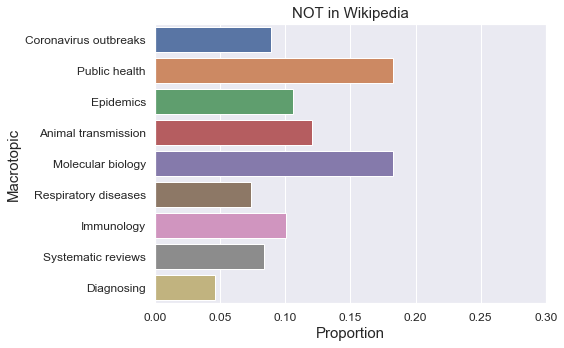

In [161]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW.pdf")

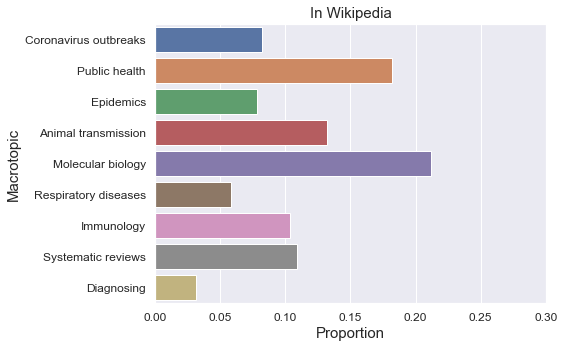

In [162]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W.pdf")

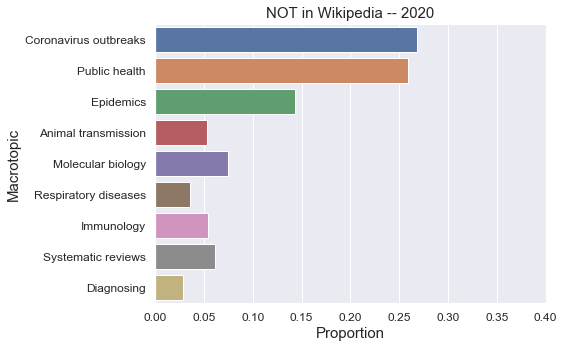

In [163]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[(df_embeddings_tm.year==2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_2020.pdf")

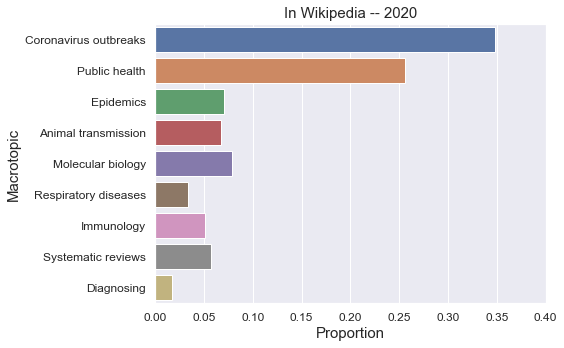

In [164]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[(df_embeddings_tm.year==2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_2020.pdf")

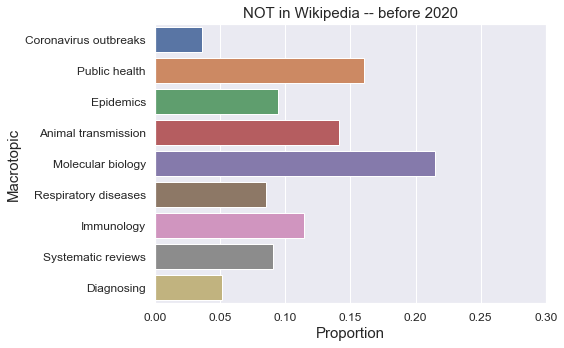

In [165]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[(df_embeddings_tm.year<2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_before_2020.pdf")

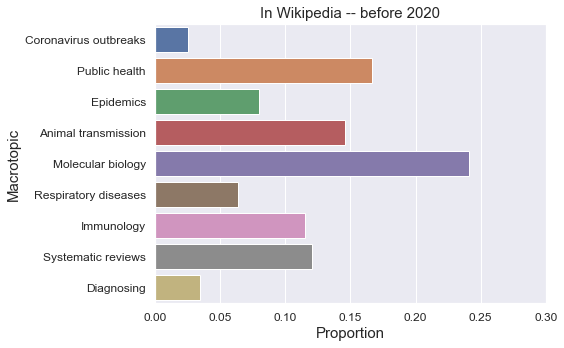

In [166]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings_tm[(df_embeddings_tm.year<2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_before_2020.pdf")

### Find a good value for the number of clusters (k-means)

#### Elbow method

In [42]:
# use PCA to reduce embedding size first (makes computations faster)
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=seed)
X_reduced= pca.fit_transform(X)
X_reduced.shape

(61324, 333)

In [45]:
# calculate distortions
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
values = range(10, 50)
for k in values:
    k_means = KMeans(n_clusters=k, random_state=seed).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

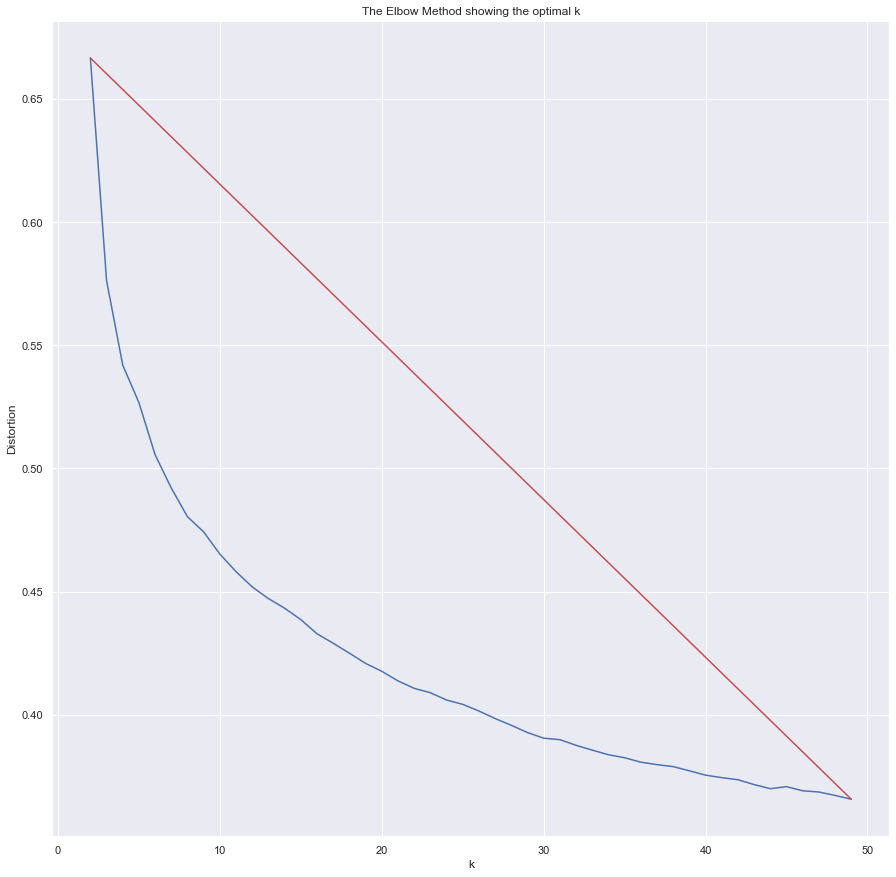

In [46]:
X_line = [values[0], values[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(values, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

#### Silhouette method

For n_clusters = 10 The average silhouette_score is : 0.055897716897725165
For n_clusters = 15 The average silhouette_score is : 0.04894153670518214
For n_clusters = 20 The average silhouette_score is : 0.04936273055262579
For n_clusters = 25 The average silhouette_score is : 0.047662626535926025
For n_clusters = 30 The average silhouette_score is : 0.04502606848610148
For n_clusters = 35 The average silhouette_score is : 0.045655548179418234
For n_clusters = 40 The average silhouette_score is : 0.045706688074604505
For n_clusters = 45 The average silhouette_score is : 0.04357707523742458
For n_clusters = 50 The average silhouette_score is : 0.04174141411594277


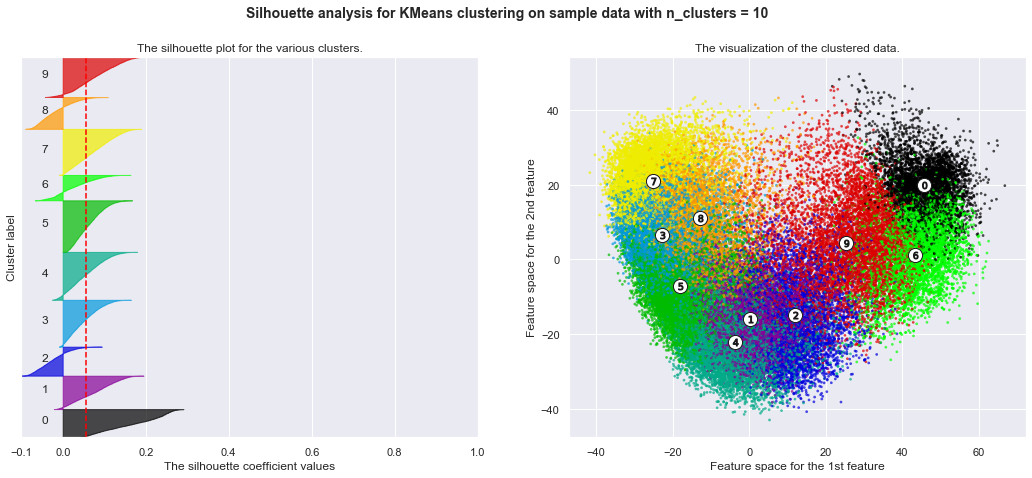

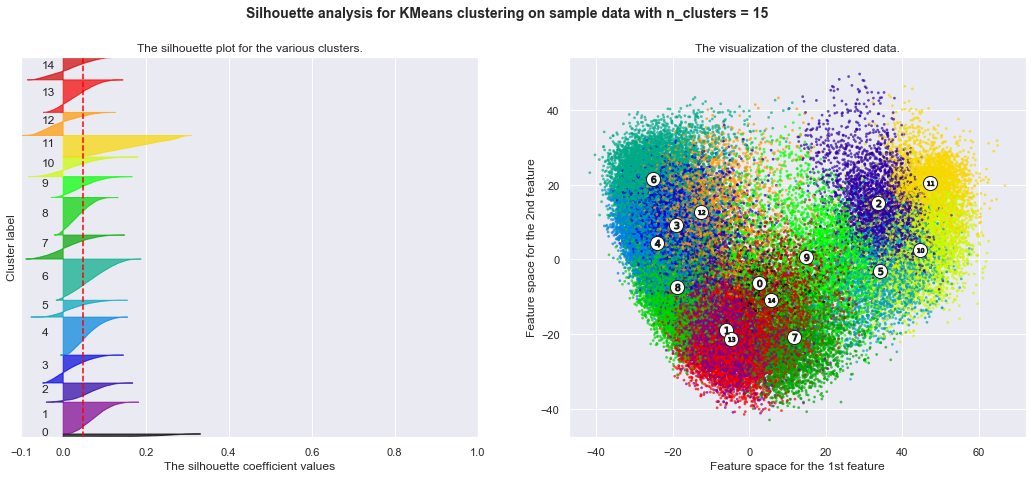

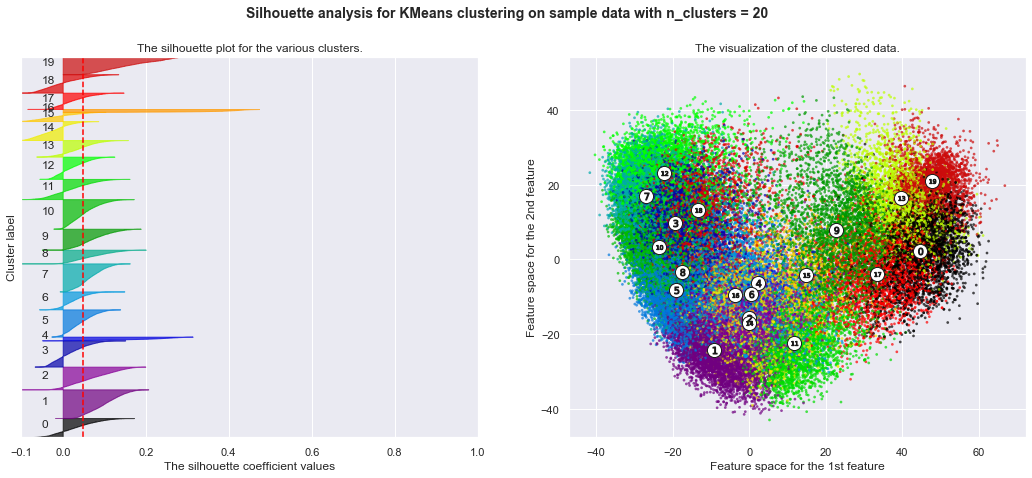

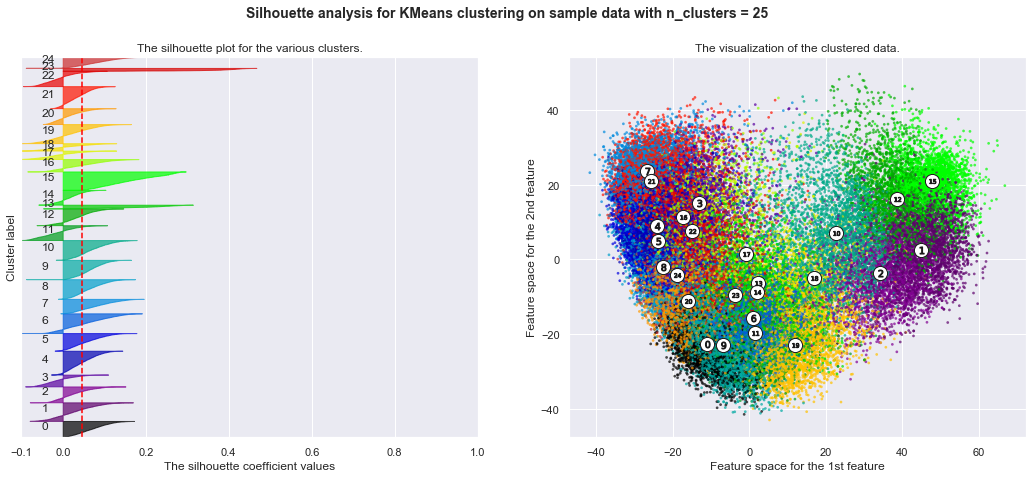

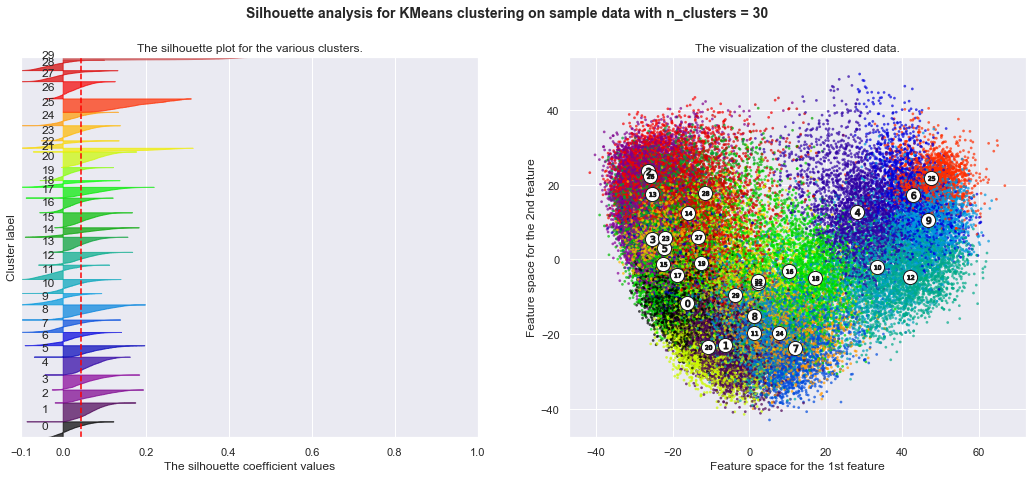

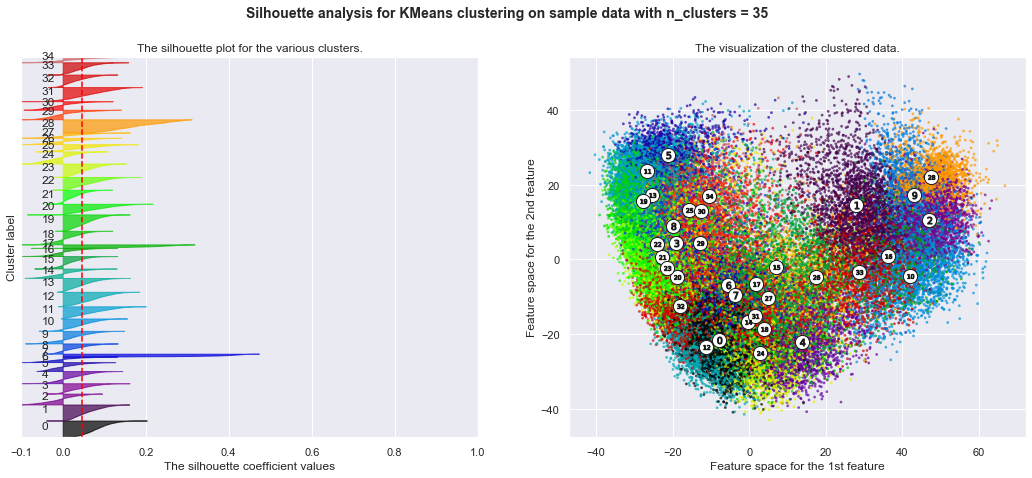

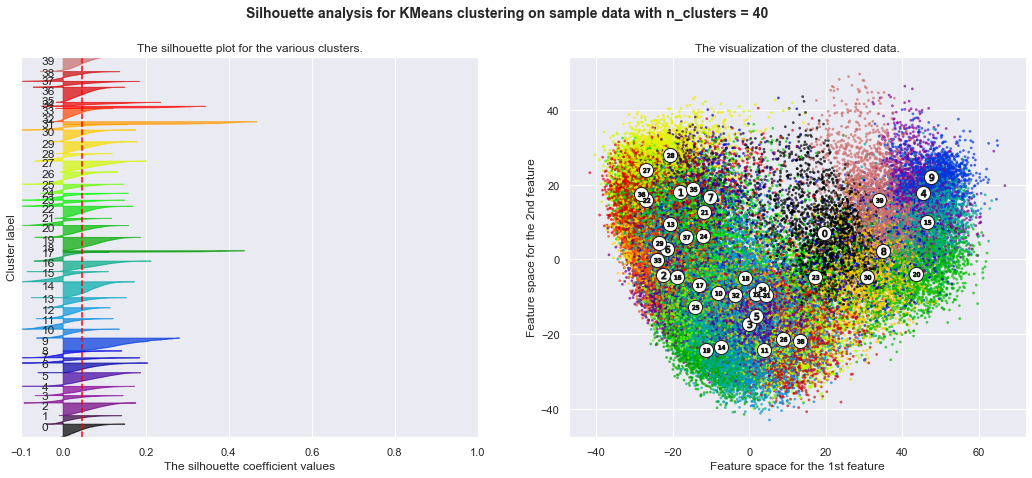

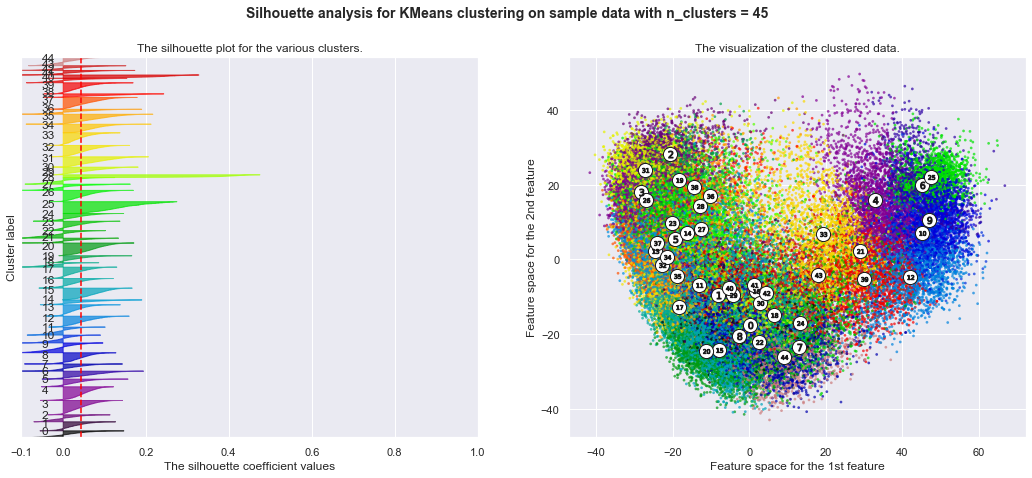

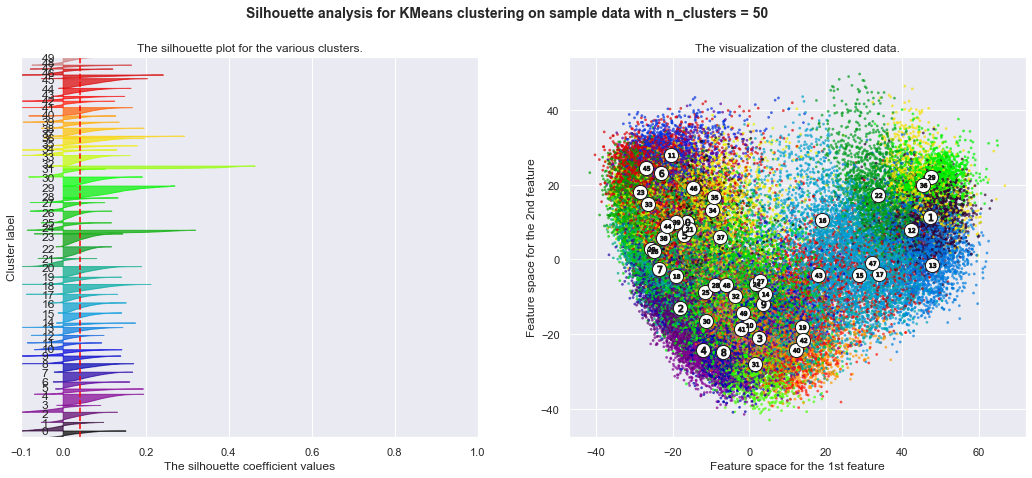

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# FROM: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.

values = range(10, 51, 5)

for k in values:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=seed)
    cluster_labels = clusterer.fit_predict(X_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()